# Question Answering with BERT
В этом семинаре мы:

1.   Получим ответ на вопрос на естественном языке от дообученного BERT
2.   Посмотрим, как устроен Stanford Question Answering Dataset (SQuAD)
3.   Самостоятельно дообучим базовый BERT на данных SQuAD


# 1. Задаём вопрос BERT

Установим библиотеку transformers

In [1]:
! pip install transformers

     |████████████████████████████████| 3.1 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 43.9 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 3.3 MB 36.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


В библиотеке Hugging Face Transformers для каждой модели всё построено вокруг трёх типов классов:
1.   **Configuration** - содержит все параметры, которые нужны, чтобы построить модель. Для предобученных моделей создаётся автоматически.
2.   **Model** - реализация модели, которая является наследником `torch.nn.Modules `или `tf.keras.Model`
3.   **Tokenizer** - содержит словарь модели и методы для кодирования/декодирования строк в список индексов эмбеддингов, которые подаются на вход модели

Все эти классы могут быть инстанцированы с помощью фабричного метода `from_pretrained()`.

In [2]:
import torch
from transformers import BertTokenizer, BertForQuestionAnswering


BERT_MODEL_NAME = "bert-large-uncased-whole-word-masking-finetuned-squad"
# see full list at https://huggingface.co/transformers/pretrained_models.html

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

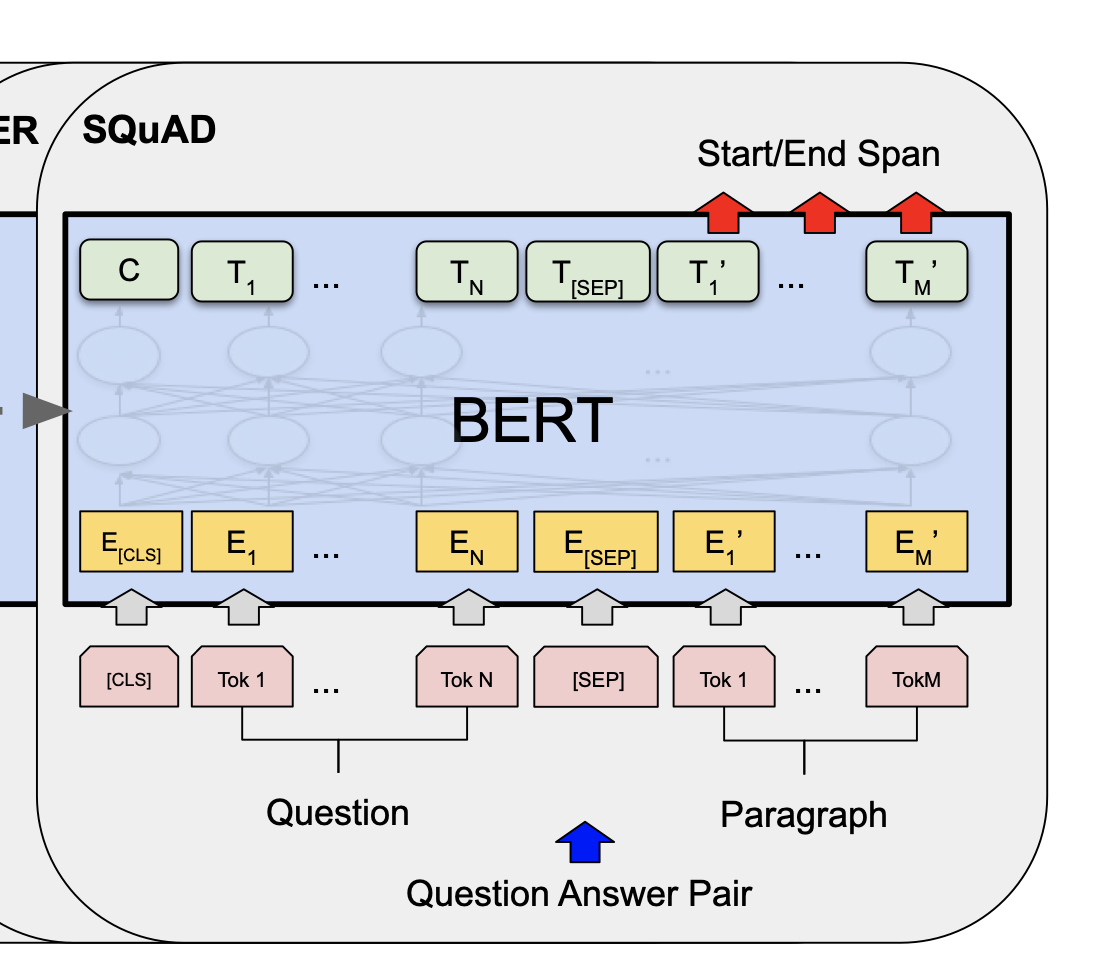

BertTokenizer знает про специальные токены и может сам их добавить к тексту

In [3]:
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.sep_token, tokenizer.sep_token_id)

[CLS] 101
[SEP] 102


In [4]:
tokenizer.encode("a", "b",
                 add_special_tokens=True)

[101, 1037, 102, 1038, 102]

In [5]:
tokenizer.convert_ids_to_tokens([1037, 1038])

['a', 'b']

Попробуем закодировать настоящий вопрос

In [17]:
context = "Saturn is the sixth planet from the Sun and the second-largest in the Solar System, after Jupiter."
question = "which planet is the largest in the Solar System?"

context = "Saturn is the sixth planet from the Sun and the second-largest in the Solar System, after Jupiter."
question = "which planet is the second-largest in the Solar System?"

In [18]:
input_ids = tokenizer.encode(question, context)

Несмотря на наличие разделяющего токена `[SEP]`, BERT всё равно должен как-то различать текст вопроса и текст, в котором ищется ответ. Для этого предусмотрены маски сегментов. Нам нужно сконструировать ещё один вектор, содержащий нули для сегмента вопроса и единицы для сегмента ответа.

In [19]:
sep_index = input_ids.index(tokenizer.sep_token_id)

num_seg_a = sep_index + 1
num_seg_b = len(input_ids) - num_seg_a

segment_ids = [0]*num_seg_a + [1]*num_seg_b

In [20]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

print("Token\t\tInpud id\tSegment id\n----------------------------------------")
for token, id, segment_id in zip(tokens, input_ids, segment_ids): 
    print("%s\t\t%d\t\t%d" % (token, id, segment_id))

Token		Inpud id	Segment id
----------------------------------------
[CLS]		101		0
which		2029		0
planet		4774		0
is		2003		0
the		1996		0
second		2117		0
-		1011		0
largest		2922		0
in		1999		0
the		1996		0
solar		5943		0
system		2291		0
?		1029		0
[SEP]		102		0
saturn		14784		1
is		2003		1
the		1996		1
sixth		4369		1
planet		4774		1
from		2013		1
the		1996		1
sun		3103		1
and		1998		1
the		1996		1
second		2117		1
-		1011		1
largest		2922		1
in		1999		1
the		1996		1
solar		5943		1
system		2291		1
,		1010		1
after		2044		1
jupiter		13035		1
.		1012		1
[SEP]		102		1


Таким образом, с помощью этих двух векторов мы закодировали вопрос для модели. 

Передав их на вход, мы получаем в качестве предсказания два вектора такой же размерности, первый показывает оценку вероятности того, что данный токен - это начала ответа в тексте, а второй - конец.

In [21]:
start_scores, end_scores = model(torch.tensor([input_ids]), 
                                 token_type_ids=torch.tensor([segment_ids]), return_dict=False)

In [22]:
answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

answer = " ".join(tokens[answer_start:answer_end+1])

print("Answer: '%s'" % answer)

Answer: 'saturn'


In [25]:
print(start_scores)

tensor([[-6.3752, -2.6608, -7.4807, -7.8514, -7.5763, -7.6708, -8.3177, -7.9415,
         -7.7761, -6.9793, -6.5745, -8.5226, -8.4069, -6.3751,  7.3829, -5.4645,
         -4.6635, -4.1476, -4.0875, -6.5797, -5.5901, -4.8356, -6.4313, -4.5860,
         -3.4183, -6.8947, -5.1415, -6.3542, -5.5009, -5.0872, -5.7640, -5.4350,
         -3.2826,  4.1936, -6.3752, -6.3754]], grad_fn=<CloneBackward0>)


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16,8)

def visualize_scores(y_tensor, title, tokens=tokens):
    y = y_tensor.detach().numpy().flatten()
    x = []
    for (i, token) in enumerate(tokens):
        x.append("%s - %d" % (token, i))
    ax = sns.barplot(x=x, y=y, ci=None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
    ax.grid(True)
    plt.title(title)
    plt.show()

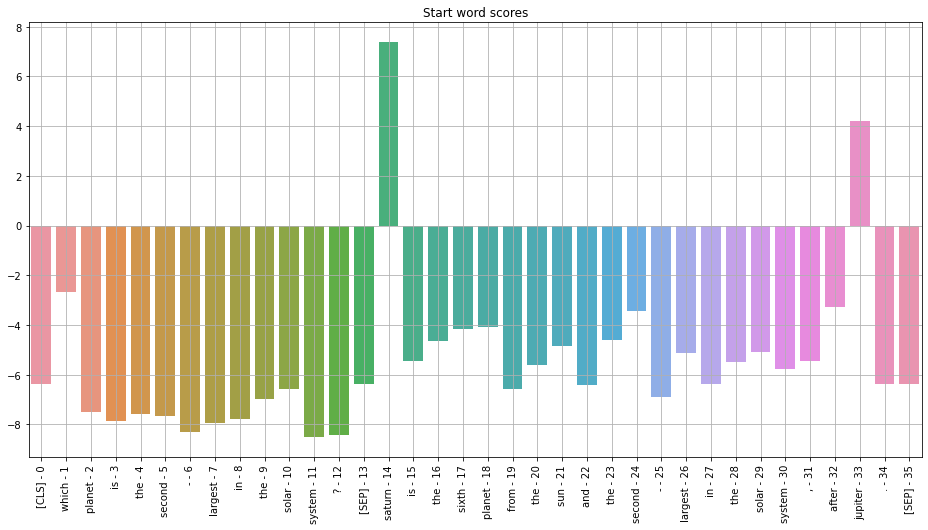

In [26]:
visualize_scores(start_scores, "Start word scores")

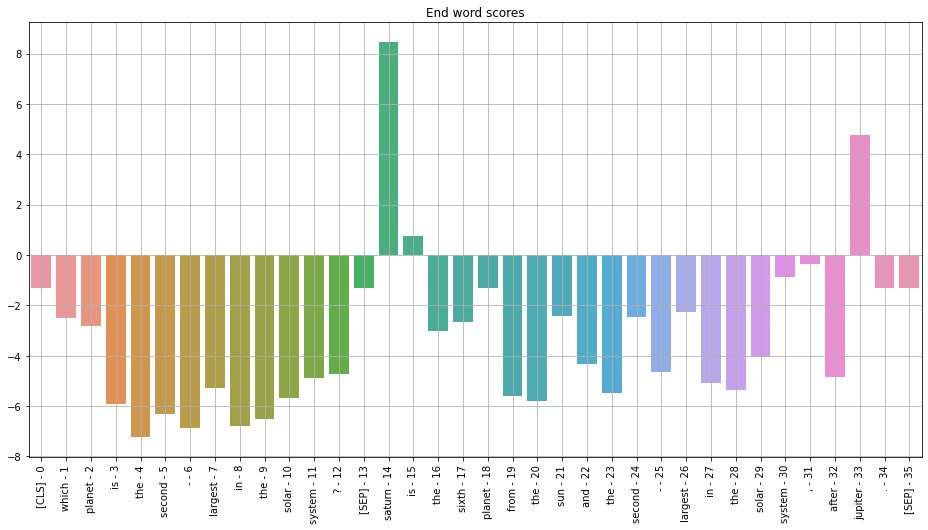

In [27]:
visualize_scores(end_scores, "End word scores")

In [28]:
del model
del tokenizer

# 2. Stanford Question Answering Dataset

Скачаем датасет SQuAD на локальную файловую систему

In [29]:
!mkdir dataset \
&& cd dataset \
&& wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json \
&& wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json

--2021-11-15 08:22:04--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘train-v2.0.json’

train-v2.0.json     100%[===================>]  40.17M   145MB/s    in 0.3s    

2021-11-15 08:22:04 (145 MB/s) - ‘train-v2.0.json’ saved [42123633/42123633]

--2021-11-15 08:22:04--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       1

Структура файла с данными выглядит следующим образом:



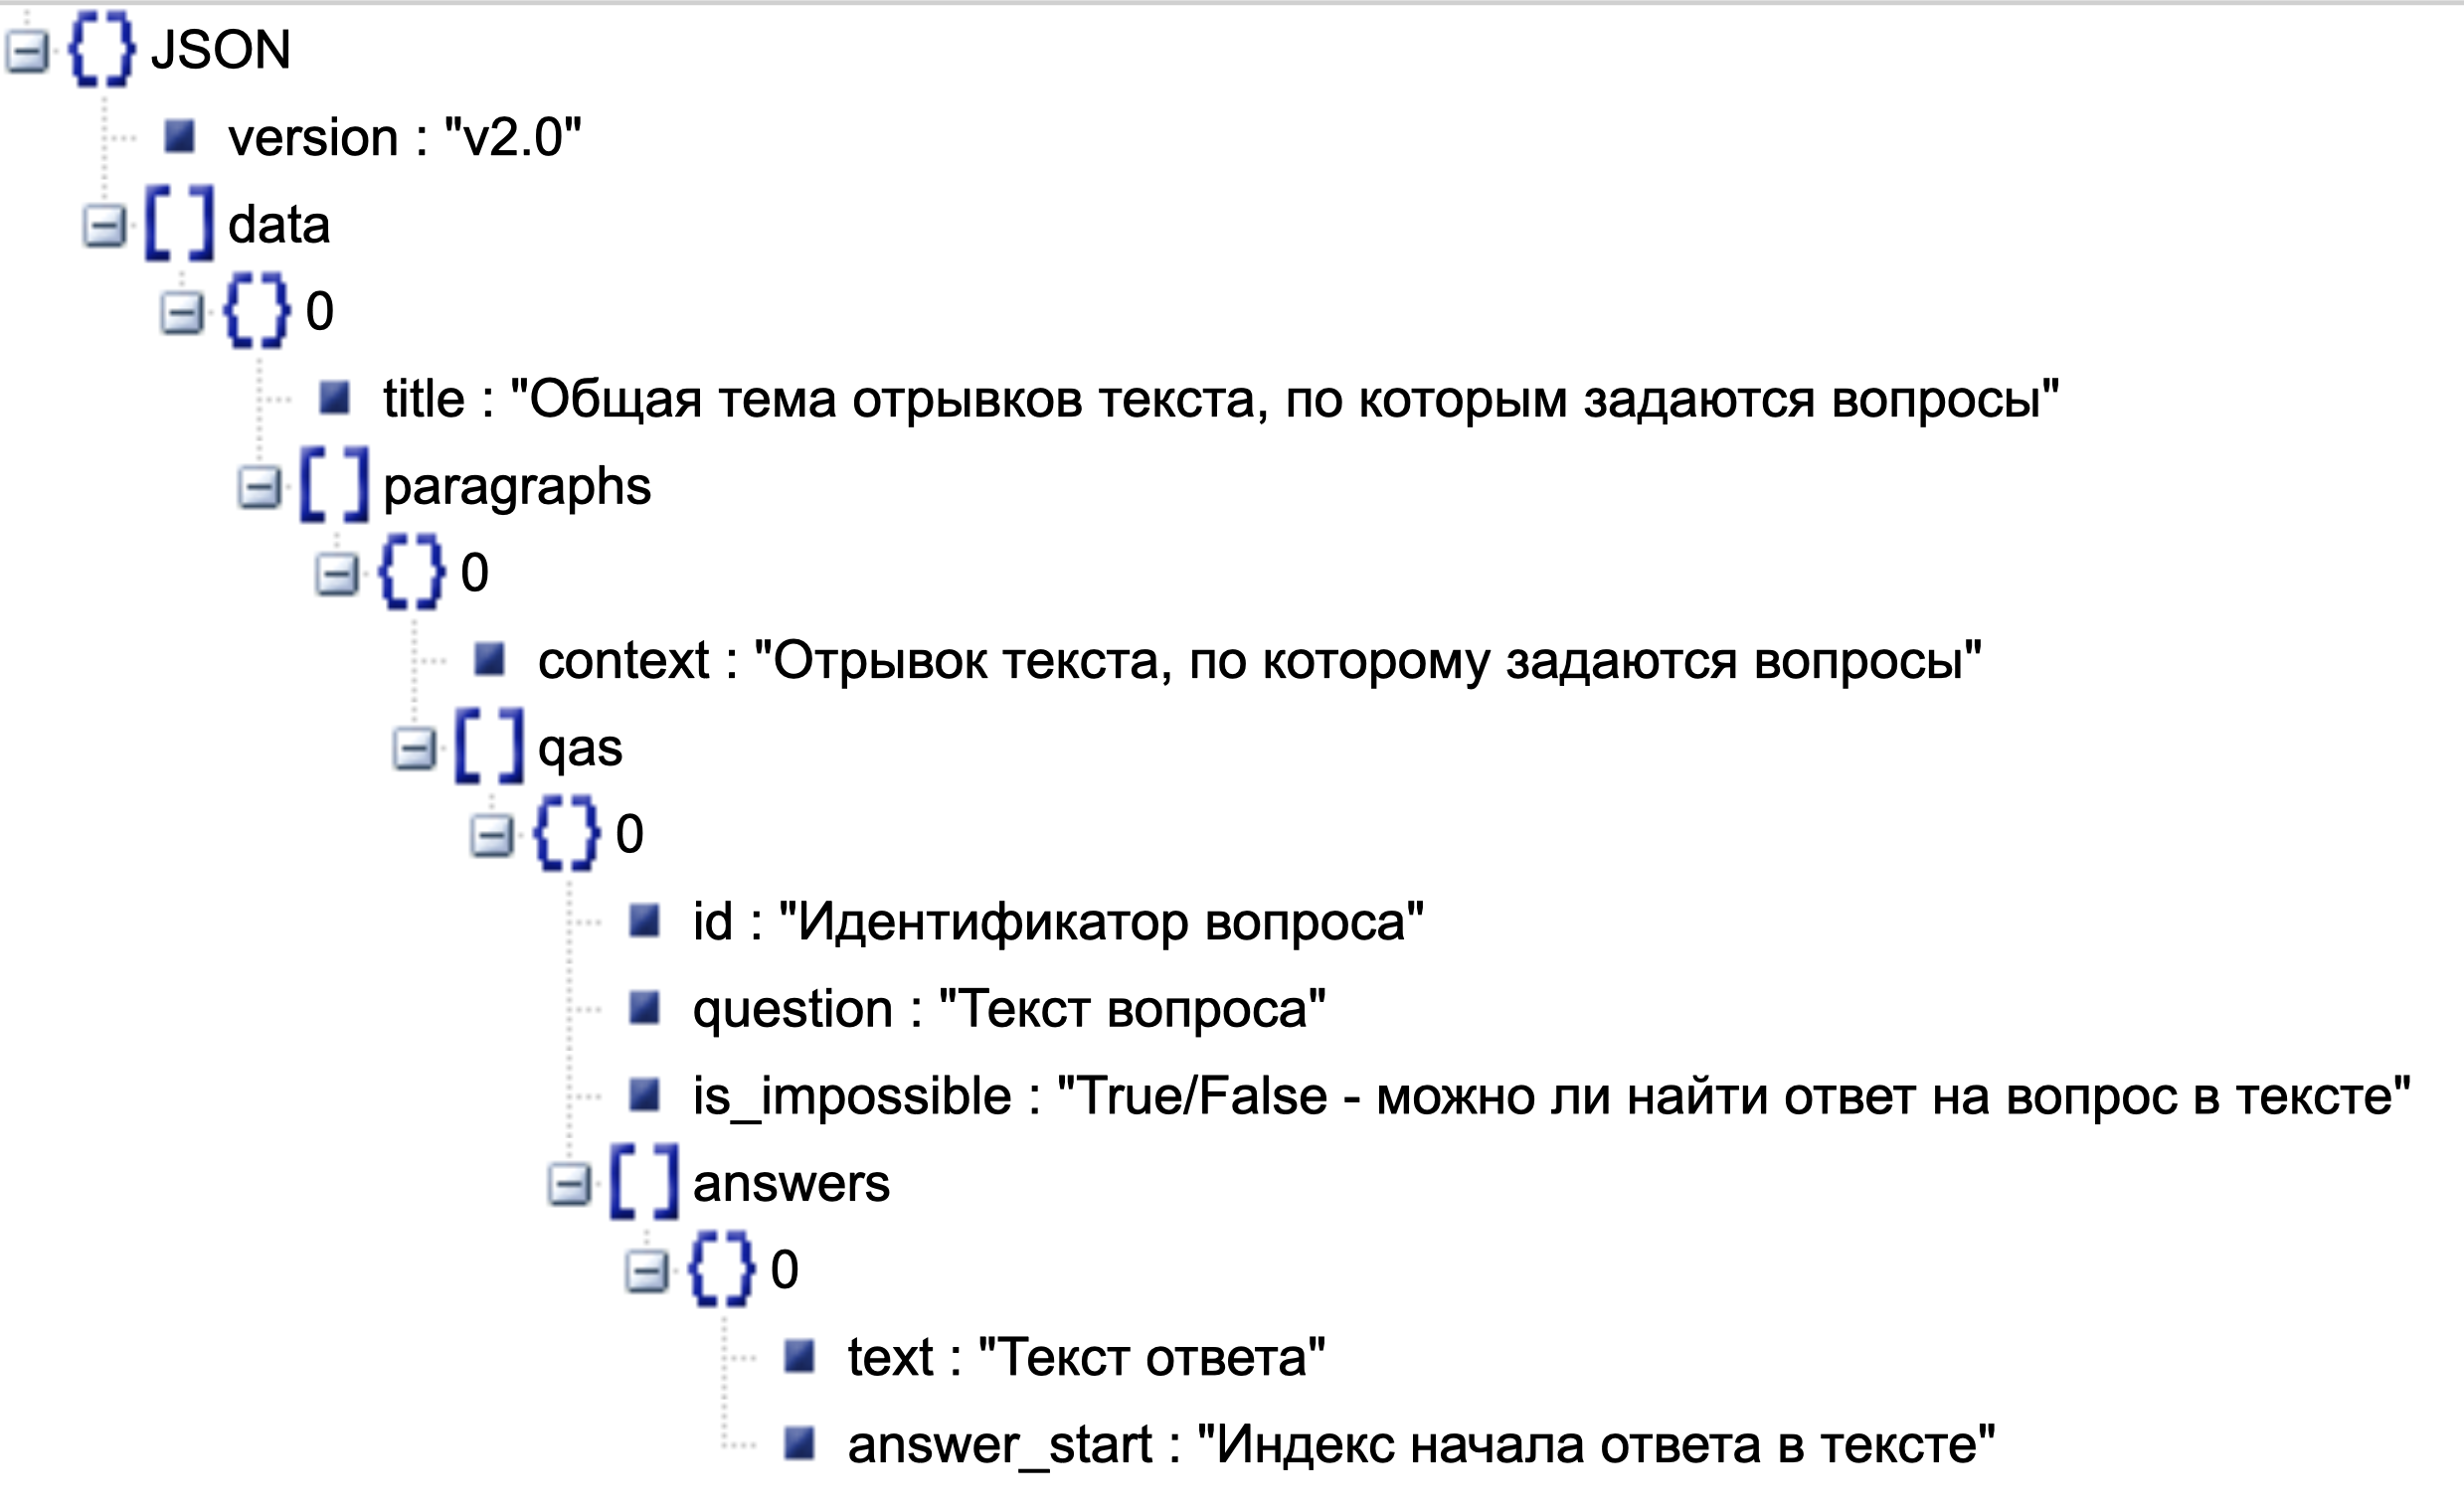

Распарсим файл с обучающей выборкой и посмотрим, что внутри

In [30]:
import json

with open("dataset/train-v2.0.json") as train_file:
  data_string = train_file.readline()
  train_dict = json.loads(data_string)

In [31]:
train_dict.keys()

dict_keys(['version', 'data'])

In [32]:
train_dict["version"], len(train_dict["data"]) 

('v2.0', 442)

In [33]:
train_dict["data"][0].keys()

dict_keys(['title', 'paragraphs'])

Отрывки текста и вопросы к ним сгруппированы по темам. 

Глянем на первые 10 тем:

In [34]:
titles = [topic["title"] for topic in train_dict["data"]]
print("\n".join(titles[:10]))

Beyoncé
Frédéric_Chopin
Sino-Tibetan_relations_during_the_Ming_dynasty
IPod
The_Legend_of_Zelda:_Twilight_Princess
Spectre_(2015_film)
2008_Sichuan_earthquake
New_York_City
To_Kill_a_Mockingbird
Solar_energy


In [35]:
sample_paragraph = train_dict["data"][3]["paragraphs"][0]

print("Sample paragraph context:\n%s" % sample_paragraph["context"])
print("-----\n Sample question:\n")
print(sample_paragraph["qas"][0])

Sample paragraph context:
The iPod is a line of portable media players and multi-purpose pocket computers designed and marketed by Apple Inc. The first line was released on October 23, 2001, about 8½ months after iTunes (Macintosh version) was released. The most recent iPod redesigns were announced on July 15, 2015. There are three current versions of the iPod: the ultra-compact iPod Shuffle, the compact iPod Nano and the touchscreen iPod Touch.
-----
 Sample question:

{'question': 'Which company produces the iPod?', 'id': '56cc55856d243a140015ef0a', 'answers': [{'text': 'Apple', 'answer_start': 105}], 'is_impossible': False}


Посчитаем количество отрывков текста и общее количество вопросов:

In [38]:
print("Number of paragraphs: %d" %
  sum([len(topic["paragraphs"]) 
       for topic in train_dict["data"]])
)
print("Number of questions: %d" %
  sum([len(paragraph["qas"]) 
       for topic in train_dict["data"] 
       for paragraph in topic["paragraphs"]])
)

Number of paragraphs: 19035
Number of questions: 130319


# 3. BERT fine-tuning on SQuAD

In [39]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('There are %d GPU(s) available.' % torch.cuda.device_count())
print('We will use the GPU:', torch.cuda.get_device_name(0))

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [40]:
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [41]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

MODEL_NAME = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [42]:
model.half() #Reduce weights floating-point precision in order to fit in GPU memory
model.to(device) #Copy model on GPU

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

В библиотеке transformers есть функции, которые могут распарсить файлы этого датасета и подготовить input модели.
Processor может прочитать файл с данными и построить список экземпляров класса `SquadExample`, а функция `squad_convert_examples_to_features()` может преобразовать этот список в input модели.

В Google Colab доступно всего 2 ядра CPU, поэтому процесс чтения и токенизации данных занимает около получаса (если повезёт, и хватит RAM, иначе всё просто зависнет), поэтому для дообучения модели мы просто скачаем файлы, полученные в результате выполнения следующих ячеек.

In [43]:
# The maximum total input sequence length after WordPiece tokenization. 
# Sequences longer than this will be truncated, and sequences shorter than this will be padded.
MAX_SEQ_LENGTH = 384 

# When splitting up a long document into chunks, how much stride to take between chunks.
DOC_STRIDE = 128

# The maximum number of tokens for the question. Questions longer than this will be truncated to this length.
MAX_QUERY_LENGTH = 64

DATA_DIR = "dataset"

train_file = "squad_train_dataset_%s_%d" % (MODEL_NAME, MAX_SEQ_LENGTH)
dev_file = "squad_dev_features_dataset_examples_%s_%d" % (MODEL_NAME, MAX_SEQ_LENGTH)

In [ ]:
import os
from transformers.data.processors.squad import SquadV2Processor
from transformers import squad_convert_examples_to_features
from multiprocessing import cpu_count


squad_processor = SquadV2Processor()


train_examples = squad_processor.get_train_examples(DATA_DIR)

_, train_dataset = squad_convert_examples_to_features(
  examples=train_examples,
  tokenizer=tokenizer,
            
  max_seq_length=MAX_SEQ_LENGTH,
  doc_stride=DOC_STRIDE,
  max_query_length=MAX_QUERY_LENGTH,
            
  is_training=True,
  return_dataset="pt",
  threads=cpu_count() 
)

torch.save({"dataset": train_dataset}, 
           os.path.join(DATA_DIR, train_file))



dev_examples = squad_processor.get_dev_examples(DATA_DIR)

dev_features, dev_dataset = squad_convert_examples_to_features(
  examples=dev_examples,
  tokenizer=tokenizer,
            
  max_seq_length=MAX_SEQ_LENGTH,
  doc_stride=DOC_STRIDE,
  max_query_length=MAX_QUERY_LENGTH,
            
  is_training=False,
  return_dataset="pt",
  threads=cpu_count() 
)

torch.save({"features": dev_features, "dataset": dev_dataset, "examples": dev_examples}, 
           os.path.join(DATA_DIR, dev_file))

convert squad examples to features:   0%|          | 0/130319 [00:00<?, ?it/s]


KeyboardInterrupt: ignored

In [44]:
!cd dataset \
&& wget https://www.dropbox.com/s/mnr7s03olmhxpes/squad_train_dataset_bert-base-uncased_384 \
&& wget https://www.dropbox.com/s/lmnpwap5a9ywlzj/squad_dev_features_dataset_examples_bert-base-uncased_384

--2021-11-15 08:30:25--  https://www.dropbox.com/s/mnr7s03olmhxpes/squad_train_dataset_bert-base-uncased_384
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/mnr7s03olmhxpes/squad_train_dataset_bert-base-uncased_384 [following]
--2021-11-15 08:30:25--  https://www.dropbox.com/s/raw/mnr7s03olmhxpes/squad_train_dataset_bert-base-uncased_384
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc035a15b943a03476474a63b83b.dl.dropboxusercontent.com/cd/0/inline/BaA7GYgfrYu93dKYw_VCPyEH-jHete8KCCbyVO7kvvdspHwEvrPKH9ugoSR7hmh2luQyQmK4wMSBvpCknqKa09HgLvCHXCa1cOZS19pDwjokCXvUSmew_MgWVHqd9nvoOsIKe1FLVnznBOQ8zfKYoeip/file# [following]
--2021-11-15 08:30:25--  https://uc035a15b943a03476474a63b83b.dl.dropboxusercontent.com/cd/0/inline/BaA

In [45]:
import os

train_dataset = torch.load(os.path.join(DATA_DIR, train_file))["dataset"]

dev_dataset_and_features = torch.load(os.path.join(DATA_DIR, dev_file))

In [46]:
from torch.utils.data import DataLoader, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

BATCH_SIZE = 16
EPOCHS = 3


train_dataloader = DataLoader(train_dataset, 
                              sampler=SequentialSampler(train_dataset), 
                              batch_size=BATCH_SIZE)

In [47]:
from tqdm import tqdm, trange
from transformers.data.metrics.squad_metrics import (
    compute_predictions_logits,
    squad_evaluate
)
from transformers.data.processors.squad import SquadResult

def to_list(tensor):
    return tensor.detach().cpu().tolist()


def evaluate(dataset_and_features, model, tokenizer, prefix="", batch_size=BATCH_SIZE, output_dir=DATA_DIR, device=device):
    dataset = dataset_and_features["dataset"]
    features = dataset_and_features["features"]
    examples = dataset_and_features["examples"]
    eval_sampler = SequentialSampler(dataset)
    eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=batch_size)

    all_results = []

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            
            feature_indices = batch[3]

            outputs = model(input_ids = batch[0], 
                            attention_mask=batch[1],
                            token_type_ids=batch[2])
            
        for i, feature_index in enumerate(feature_indices):
            eval_feature = features[feature_index.item()]
            unique_id = int(eval_feature.unique_id)
            start_logits, end_logits = [to_list(output[i]) for output in outputs]
            result = SquadResult(unique_id, start_logits, end_logits)
            all_results.append(result)

    output_prediction_file = os.path.join(output_dir, "predictions_{}.json".format(prefix))
    output_nbest_file = os.path.join(output_dir, "nbest_predictions_{}.json".format(prefix))
    output_null_log_odds_file = os.path.join(output_dir, "null_odds_{}.json".format(prefix))

    predictions = compute_predictions_logits(
        all_examples=examples,
        all_features=features,
        all_results=all_results,
        n_best_size=20,
        max_answer_length=30,
        do_lower_case=True,
        output_prediction_file=output_prediction_file,
        output_nbest_file=output_nbest_file,
        output_null_log_odds_file=output_null_log_odds_file,
        verbose_logging=False,
        version_2_with_negative=True,
        null_score_diff_threshold=0.0,
        tokenizer=tokenizer
     )
    
    results = squad_evaluate(examples, predictions)
    return results

In [49]:
from transformers import AdamW, get_linear_schedule_with_warmup


optimizer = AdamW(model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-4)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = len(train_dataloader) * EPOCHS)

In [50]:
from tqdm import tqdm

global_step, train_loss = 1, 0


model.zero_grad()

for epoch in range(1, EPOCHS + 1):
    print("Epoch %d" % epoch)
    
    for batch in tqdm(train_dataloader, desc="Iteration"):
    
        model.train()
        batch = tuple(t.to(device) for t in batch)

        outputs = model(input_ids = batch[0], 
                        attention_mask=batch[1],
                        token_type_ids=batch[2],
                        start_positions=batch[3], 
                        end_positions=batch[4])
         
        loss = outputs[0]

        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()

        model.zero_grad()

        train_loss += loss.item()
        global_step += 1

    print("Epoch %d" % epoch)
    print("Average loss: %f" % train_loss / global_step)    
    
    eval_result = evaluate(dev_dataset_and_features, model, tokenizer, prefix=epoch)

    print("Evaluation result: ")
    print(eval_result)

Epoch 1


Iteration:   0%|          | 14/8247 [00:55<9:02:23,  3.95s/it]


KeyboardInterrupt: ignored